In [26]:
import torch 
import torch.nn as nn
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
DATASET_PATH= 'https://raw.githubusercontent.com/magistery-tps/time-series-tp/master/datasets/consumo_energetico_diario.csv'
dataset = pd.read_csv(DATASET_PATH,parse_dates=['dia'])
dataset.columns = dataset.columns.str.lower()

dataset.head()

,dia,mwh,tmp
0,2005-12-01,81445.928,18.104167
1,2005-12-02,81749.888,17.904167
2,2005-12-03,72134.590,19.562500
3,2005-12-04,63452.628,18.854167
4,2005-12-05,81508.078,21.941667


Separo en train y test

In [3]:
tiempo_ini='2012-06-03'
data=dataset[(dataset.dia>tiempo_ini)]
data.reset_index(inplace=True)

In [4]:
train_set=dataset[(dataset.dia>tiempo_ini)&(dataset.dia<'1-1-2020')] #ultimo dia train 31/12/2019, 
train_set.reset_index(inplace=True)

test_set=dataset[(dataset.dia>='1-1-2020')] #ultimo dia train 31/12/2019
test_set.reset_index(inplace=True)

N_test=len(test_set)

In [5]:
train_mwh=train_set.mwh.values.astype(float)
test_mwh=test_set.mwh.values.astype(float)

In [6]:
sc=MinMaxScaler(feature_range=(-1,1))
train_norm=sc.fit_transform(train_mwh.reshape(-1,1))
train_norm=torch.FloatTensor(train_norm).view(-1)

In [7]:
def create_input_output(input_data,window,ndays=1):
    input_output=[]
    data_size=len(input_data)
    for i in range(data_size - window - ndays):
        train_seq=input_data[i:i + window]
        train_label=input_data[i + window + ndays:i + window + ndays + 1]
        input_output.append((train_seq,train_label))
    return input_output

ndays=10
window = 30
train_input_output =create_input_output(train_norm,window,ndays)
train_input_output[:2]

[(tensor([ 0.0249,  0.1520,  0.3620,  0.4283,  0.3467,  0.0401, -0.2096,  0.0982,
           0.0590, -0.1610, -0.3042, -0.0240, -0.0238, -0.0960,  0.2881,  0.2079,
          -0.1914,  0.0058,  0.0016, -0.2942, -0.4799,  0.0803,  0.0703, -0.1424,
          -0.2360, -0.1930, -0.3315, -0.6268, -0.0104,  0.2103]),
  tensor([0.0348])),
 (tensor([ 0.1520,  0.3620,  0.4283,  0.3467,  0.0401, -0.2096,  0.0982,  0.0590,
          -0.1610, -0.3042, -0.0240, -0.0238, -0.0960,  0.2881,  0.2079, -0.1914,
           0.0058,  0.0016, -0.2942, -0.4799,  0.0803,  0.0703, -0.1424, -0.2360,
          -0.1930, -0.3315, -0.6268, -0.0104,  0.2103,  0.3894]),
  tensor([-0.0023]))]

In [8]:
class NN_conv(nn.Module):
    def __init__(self):
        super(NN_conv, self).__init__()
        self.conv1= nn.Sequential(
            nn.Conv1d(
                in_channels=1,
                out_channels=5,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3),
        )
        self.conv2= nn.Sequential(
            nn.Conv1d(
                in_channels=5,
                out_channels=8,
                kernel_size=5,
                stride=1,
                padding=2,
            ),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )
        self.out=nn.Linear(40,1)
    
    def forward(self,x):
        x=self.conv1(x)
        x=self.conv2(x)
        x=x.view(-1,8*5)
        output=self.out(x)
        return output
                

In [9]:
model=NN_conv()
loss_function=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

In [10]:
epochs=200

for i in range(epochs):
    for inputs, labels in train_input_output:
        optimizer.zero_grad()
        inputs=inputs.view(1,1,window)
        y_pred=model(inputs)
        
        single_loss=loss_function(y_pred,labels)
        single_loss.backward()
        optimizer.step()
    if i%10 ==1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

C:\Users\Flavia\anaconda3\envs\series-temporales\lib\site-packages\torch\nn\modules\loss.py:520: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:   1 loss: 0.09994885
epoch:  11 loss: 0.25324556
epoch:  21 loss: 0.23817505
epoch:  31 loss: 0.18604554
epoch:  41 loss: 0.13958973
epoch:  51 loss: 0.25519288
epoch:  61 loss: 0.16870709
epoch:  71 loss: 0.22804259
epoch:  81 loss: 0.25372428
epoch:  91 loss: 0.11207364
epoch: 101 loss: 0.15941776
epoch: 111 loss: 0.18969734
epoch: 121 loss: 0.19385700
epoch: 131 loss: 0.16318013
epoch: 141 loss: 0.16180523
epoch: 151 loss: 0.15359874
epoch: 161 loss: 0.13448884
epoch: 171 loss: 0.11459821
epoch: 181 loss: 0.13315973
epoch: 191 loss: 0.12690361


Se hacen las predicciones

In [11]:
test_norm=sc.transform(test_mwh.reshape(-1,1))
test_norm=torch.FloatTensor(test_norm).view(-1)
test_input_output=create_input_output(test_norm,window,ndays)
test_input_output[:2]

[(tensor([-0.7130, -0.3882, -0.2403, -0.3498, -0.2983, -0.2833, -0.2098,  0.0809,
           0.2216,  0.2106,  0.0093, -0.1724, -0.0167,  0.1368,  0.0195, -0.4249,
          -0.3569, -0.3785, -0.0858,  0.7092,  0.3505,  0.2676,  0.3790,  0.4736,
           0.3829,  0.1031, -0.2400, -0.1399, -0.1138, -0.4633]),
  tensor([-0.4744])),
 (tensor([-0.3882, -0.2403, -0.3498, -0.2983, -0.2833, -0.2098,  0.0809,  0.2216,
           0.2106,  0.0093, -0.1724, -0.0167,  0.1368,  0.0195, -0.4249, -0.3569,
          -0.3785, -0.0858,  0.7092,  0.3505,  0.2676,  0.3790,  0.4736,  0.3829,
           0.1031, -0.2400, -0.1399, -0.1138, -0.4633, -0.3306]),
  tensor([-0.3434]))]

In [12]:
y_pred_norm=[]
for inputs, labels in test_input_output:
    with torch.no_grad():
        inputs=inputs.view(1,1,window)
        y_pred_norm.append(model(inputs).item())
y_pred_norm[:5]

[0.05871143937110901,
 0.03392684459686279,
 -0.07051615417003632,
 -0.08591654896736145,
 0.05683228373527527]

In [13]:
y_pred=sc.inverse_transform(np.array(y_pred_norm).reshape(-1,1))

In [14]:
y_true=test_mwh[window+ndays:]
#y_true=sc.transform(y_true.reshape(-1,1))
mean_squared_error(y_true, y_pred)

413032149.28047425

In [15]:
data_norm=sc.transform(data['tmp'].values.reshape(-1,1))

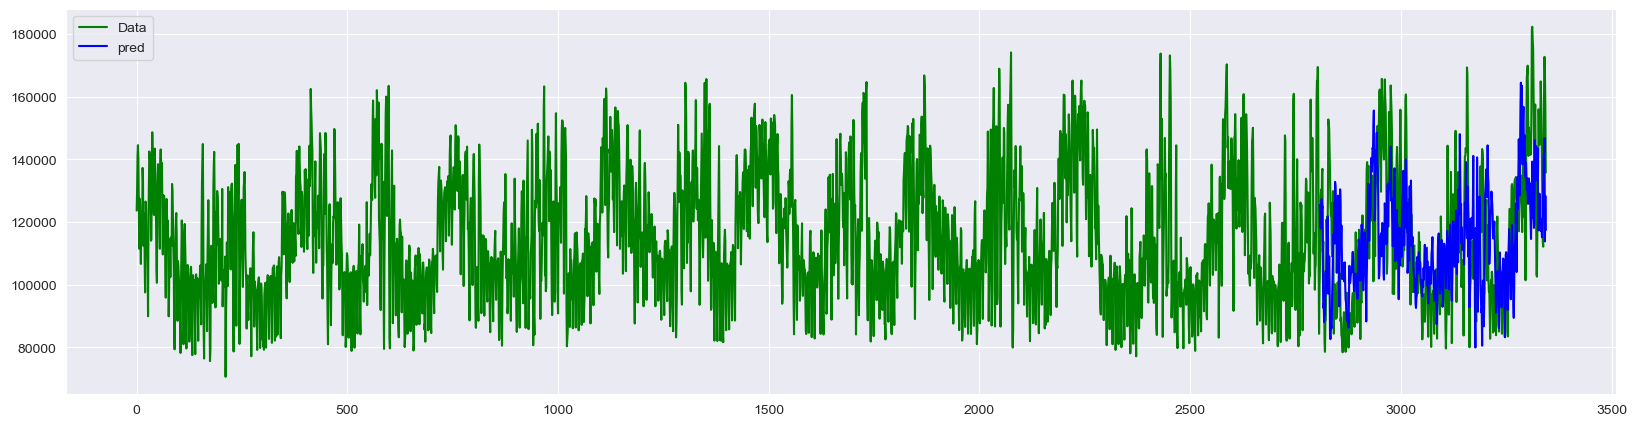

In [28]:
plt.figure(figsize=[20,5])
sns.set_style("darkgrid")
plt.plot(data.mwh,color='green',label='Data')
plt.plot(range(len(train_set)+window+ndays, len(train_set)+len(test_set)),y_pred,label='pred',color='blue')
plt.legend()

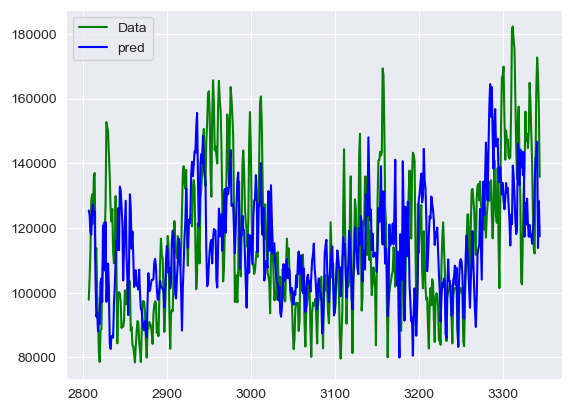

In [29]:
plt.plot(range(len(train_set)+window+ndays, len(train_set)+len(test_set)),y_true,color='green',label='Data')
plt.plot(range(len(train_set)+window+ndays, len(train_set)+len(test_set)),y_pred,color='blue',label='pred')
plt.legend()

In [30]:
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mape = mean_absolute_percentage_error(y_true, y_pred)
print('Test - Error cuadratico medio: ', mse)
print('Test - Error absoluto medio: ',mae)
print('Test - Error porcentual abs:',mape)

Test - Error cuadratico medio:  413032149.28047425
Test - Error absoluto medio:  16126.388743009522
Test - Error porcentual abs: 0.13743011952950066
